In [1]:
import torch
from datasets import load_dataset, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from config import load_config, get_model_name

config = load_config("pixel_mdvae")
train_loader, test_loader, val_loader = load_dataset(config["data_params"])

model_name = get_model_name(config)

from models import PixelMDVAE
import torch

model = PixelMDVAE(config["model_params"])

randn = torch.randn(32, 1, 28, 28)
randn2 = torch.randn(32, 1, 28, 28)

output, _, _,_ = model(randn, randn2,_)

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
from trainers import BaseModule
from models import PixelMDVAE

class PixelMDVAETrainer(BaseModule):
    def __init__(self, hidden_dims = [128, 256], latent_dim = 2):
        model = PixelMDVAE(hidden_dims, latent_dim)
        super(PixelMDVAETrainer, self).__init__(model)
        
    def forward(self, x, x_cond, y):
        return self.model(x,x_cond)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, mu, log_var, z = self(x, x_cond, y)
        loss = self.model.loss(x, x_hat, mu, log_var)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True)
        return loss['loss']
    
    def load_model_checkpoint(model_name):
        path = ('checkpoints/' + model_name + '.ckpt')
        return PixelMDVAETrainer.load_from_checkpoint(path)

In [2]:
from trainers import SuperTrainer, VAEModule

model = VAEModule(config['model_params'], model_name=config['model_name'])

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which wi

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /Home/siv34/edzak2974/projects/MastersThesis/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name  | Type       | Params
-------------------------------------
0 | model | PixelMDVAE | 11.1 M
-------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.574    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 469/469 [00:07<00:00, 60.87it/s, v_num=cpqx, train_recon_loss=2.41e+3, train_recon_loss_2=1.59e+3, train_kl_loss=23.90, train_loss=4.02e+3, val_recon_loss=3.54e+3, val_recon_loss_2=2.43e+3, val_kl_loss=31.00, val_loss=6e+3]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 469/469 [00:09<00:00, 51.11it/s, v_num=cpqx, train_recon_loss=2.41e+3, train_recon_loss_2=1.59e+3, train_kl_loss=23.90, train_loss=4.02e+3, val_recon_loss=3.54e+3, val_recon_loss_2=2.43e+3, val_kl_loss=31.00, val_loss=6e+3]


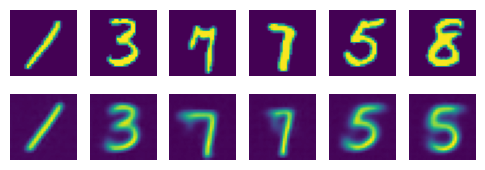

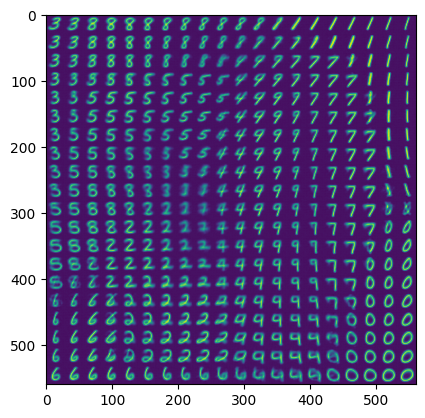

In [ ]:
from trainers import VAEModule
model = VAEModule.load_model_checkpoint(model_name)
model.eval()

from plotting import plot_samples_with_reconstruction
from plotting import plot_latent_images

plot_samples_with_reconstruction(model, next(iter(test_loader)))
plot_latent_images(model)